In [1]:
## Path for modules

import sys

import numpy as np
import xarray as xr

from netCDF4 import Dataset

sys.path.insert(0,"/mnt/meom/workdir/henelle/Notebooks/git/xscale")
import xscale
import xscale.spectral.fft as xfft

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import numpy.ma as ma

import matplotlib.cm as mplcm
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

seq_cmap = mplcm.Blues
div_cmap = mplcm.seismic

import matplotlib.pyplot as plt
import matplotlib as mpl
from datetime import date, datetime

import pandas as pd

import seaborn as sns
sns.set(color_codes=True)

%matplotlib inline

In [2]:
## Dataset

dirfilt_00 = "/mnt/meom/workdir/henelle/eNATL60/eNATL60-BLB002-S/1h/ACO/"
dirfilt_T0 = "/mnt/meom/workdir/henelle/eNATL60/eNATL60-BLBT02-S/1h/ACO/"

In [3]:
## JAS files

tfileJAS_strain00 = dirfilt_00 + 'eNATL60ACO-BLB002_y2009m07d24.1h_strain10m.nc'
tfileJAS_strainT0 = dirfilt_T0 + 'eNATL60ACO-BLBT02_y2009m07d24.1h_strain10m.nc'
tfileJAS_curl00   = dirfilt_00 + 'eNATL60ACO-BLB002_y2009m07d24.1h_curl10m.nc'
tfileJAS_curlT0   = dirfilt_T0 + 'eNATL60ACO-BLBT02_y2009m07d24.1h_curl10m.nc'

In [4]:
## JFM files

tfileJFM_strain00 = dirfilt_00 + 'eNATL60ACO-BLB002_y2010m01d24.1h_strain10m.nc'
tfileJFM_strainT0 = dirfilt_T0 + 'eNATL60ACO-BLBT02_y2010m01d24.1h_strain10m.nc'
tfileJFM_curl00   = dirfilt_00 + 'eNATL60ACO-BLB002_y2010m01d24.1h_curl10m.nc'
tfileJFM_curlT0   = dirfilt_T0 + 'eNATL60ACO-BLBT02_y2010m01d24.1h_curl10m.nc'

In [5]:
# Curl files

fcurl_JAS_00 = xr.open_dataset(tfileJAS_curl00)
fcurl_JAS_T0 = xr.open_dataset(tfileJAS_curlT0)

fcurl_JFM_00 = xr.open_dataset(tfileJFM_curl00)
fcurl_JFM_T0 = xr.open_dataset(tfileJFM_curlT0)

In [6]:
# Strain files

fstrain_JAS_00 = xr.open_dataset(tfileJAS_strain00)
fstrain_JAS_T0 = xr.open_dataset(tfileJAS_strainT0)

fstrain_JFM_00 = xr.open_dataset(tfileJFM_strain00)
fstrain_JFM_T0 = xr.open_dataset(tfileJFM_strainT0)

In [7]:
navlat = fcurl_JAS_00['nav_lat']
navlon = fcurl_JAS_00['nav_lon']

In [8]:
## Curl

curl_JAS_00 = fcurl_JAS_00['socurloverf']
curl_JAS_T0 = fcurl_JAS_T0['socurloverf']

curl_JFM_00 = fcurl_JFM_00['socurloverf']
curl_JFM_T0 = fcurl_JFM_T0['socurloverf']

In [9]:
## Strain

strain_JAS_00 = fstrain_JAS_00['sostrainoverf']
strain_JAS_T0 = fstrain_JAS_T0['sostrainoverf']

strain_JFM_00 = fstrain_JFM_00['sostrainoverf']
strain_JFM_T0 = fstrain_JFM_T0['sostrainoverf']

In [16]:
curl_JAS_00

<xarray.DataArray 'socurloverf' (time_counter: 24, y: 1191, x: 781)>
[22324104 values with dtype=float32]
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2009-07-24T00:30:00 ... 2009-07-24T23:30:00
Dimensions without coordinates: y, x
Attributes:
    units:             -
    valid_min:         -1000.0
    valid_max:         1000.0
    long_name:         Relative_Vorticity (curl)
    short_name:        socurl
    iweight:           1
    online_operation:  N/A
    axis:              TYX
    savelog10:         0.0

In [10]:
## Selecting box

box    = (-31,-28,33,36)
#box = (-31.5,-27,30.6,36)
domain = (box[0] < navlon)*(navlon < box[1])*(box[2] < navlat)*(navlat < box[3])
where  = np.where(domain)


lats = navlat[where]
lons = navlon[where]

ind  = np.unravel_index(np.argmin(lats, axis=None), lats.shape)
jmin = where[0][ind[0]]
ind  = np.unravel_index(np.argmax(lats, axis=None), lats.shape)
jmax = where[0][ind[0]]
ind  = np.unravel_index(np.argmin(lons, axis=None), lons.shape)
imin = where[1][ind[1]]
ind  = np.unravel_index(np.argmax(lons, axis=None), lons.shape)
imax = where[1][ind[1]]

In [11]:
print(jmin);print(jmax)
print(imin);print(imax)

667
882
384
563


In [12]:
## Selecting data in the box

curl_filt_box_T0   = np.mean(curl_JAS_T0[:,jmin:jmax+1,imin:imax+1].stack(z=('x', 'y')),axis=0)
curl_filt_box_00   = np.mean(curl_JAS_00[:,jmin:jmax+1,imin:imax+1].stack(z=('x', 'y')),axis=0)
strain_filt_box_T0 = np.mean(strain_JAS_T0[:,jmin:jmax+1,imin:imax+1].stack(z=('x', 'y')),axis=0)
strain_filt_box_00 = np.mean(strain_JAS_00[:,jmin:jmax+1,imin:imax+1].stack(z=('x', 'y')),axis=0)

In [13]:
## Calculating weights

weights_curl_filt_box_T0   = np.ones_like(curl_filt_box_T0)/float(len(curl_filt_box_T0))
weights_curl_filt_box_00   = np.ones_like(curl_filt_box_00)/float(len(curl_filt_box_00))
weights_strain_filt_box_T0 = np.ones_like(strain_filt_box_T0)/float(len(strain_filt_box_T0))
weights_strain_filt_box_00 = np.ones_like(strain_filt_box_00)/float(len(strain_filt_box_00))

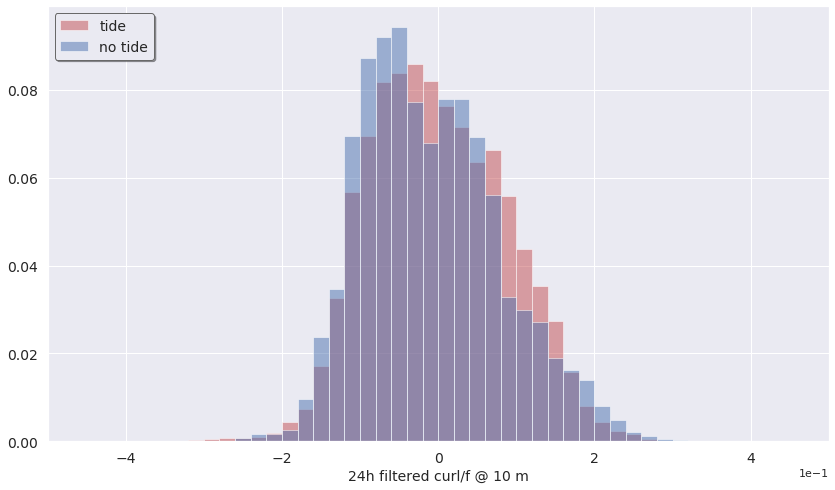

In [14]:
## Histogram of PDF - curl

fig = plt.figure(figsize=(14,8))
axes1 = fig.add_subplot(1,1,1)

axes1.hist(curl_filt_box_T0,100,alpha=0.5,range=(-1,1),color='r',weights=weights_curl_filt_box_T0,label='tide')
axes1.hist(curl_filt_box_00,100,alpha=0.5,range=(-1,1),color='b',weights=weights_curl_filt_box_00,label='no tide')

plt.xlim(-0.5,0.5)
plt.tick_params(labelsize=14)
plt.ticklabel_format(style='sci',axis='x',scilimits=(0,0))
plt.xlabel('24h filtered curl/f @ 10 m',size=14)
plt.legend(fontsize=14,loc=2,shadow=True,edgecolor='dimgray')

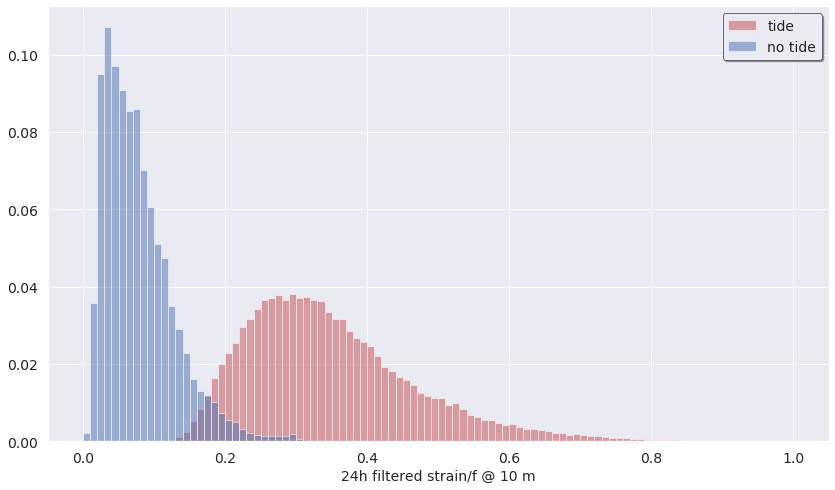

In [15]:
## Histogram of PDF - strain

fig = plt.figure(figsize=(14,8))
axes1 = fig.add_subplot(1,1,1)

axes1.hist(strain_filt_box_T0,100,alpha=0.5,range=(0,1),color='r',weights=weights_strain_filt_box_T0,label='tide')
axes1.hist(strain_filt_box_00,100,alpha=0.5,range=(0,1),color='b',weights=weights_strain_filt_box_00,label='no tide')

plt.tick_params(labelsize=14)
plt.ticklabel_format(style='sci',axis='x',scilimits=(0,0))
plt.xlabel('24h filtered strain/f @ 10 m',size=14)
plt.legend(fontsize=14,shadow=True,edgecolor='dimgray')